In [1]:
import os
import shutil
import sys
import time
import warnings
from random import sample

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data.sampler import SubsetRandomSampler, Sampler, SequentialSampler

from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

import pytorch_lightning as L
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer
from torchmetrics.functional import mean_squared_error, mean_absolute_error

from pymatgen.core.composition import Composition

import torch
from torch.utils.data import DataLoader,random_split
from torch.nn import L1Loss, MSELoss, HuberLoss

data_type_np = np.float32
data_type_torch = torch.float32

import wandb

In [2]:
def RobustL1Loss(output, log_std, target):
    """
    Robust L1 loss using a lorentzian prior. Allows for estimation
    of an aleatoric uncertainty.
    """
    loss = np.sqrt(2.0) * torch.abs(output - target) * torch.exp(-log_std) + log_std
    return torch.mean(loss)


def RobustL2Loss(output, log_std, target):
    """
    Robust L2 loss using a gaussian prior. Allows for estimation
    of an aleatoric uncertainty.
    """
    # NOTE can we scale log_std by something sensible to improve the OOD behaviour?
    loss = 0.5 * torch.pow(output - target, 2.0) * torch.exp(-2.0 * log_std) + log_std
    return torch.mean(loss)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()if p.requires_grad)

In [4]:
from cgcnn.data import CIFData, collate_pool

## The data should be prepared as discribed in CIFdata doc-string

class CGCNNDataModule(L.LightningDataModule):
    def __init__(self, root_dir: str,
                 train_ratio: 0.8,
                 val_ratio: 0.1, 
                 test_ratio: 0.1,
                 collate_fn=collate_pool,
                 classification = False,
                 batch_size = 256,
                 num_workers = 0,
                 pin_memory = True,
                 random_seed = 123):
        super().__init__()
        self.random_seed=random_seed
        self.dataset = CIFData(root_dir=root_dir, max_num_nbr=12, radius=10, dmin=0, step=0.2, random_seed=self.random_seed)
        total_size = len(self.dataset)
        indices = list(range(total_size))
        
        self.collate_fn=collate_pool
        
        train_size = int(train_ratio * total_size)
        val_size = int(val_ratio * total_size)
        test_size = total_size - train_size - val_size
        
        self.g = torch.Generator().manual_seed(self.random_seed)
        train_dataset, val_dataset, test_dataset = random_split(self.dataset, [train_size, val_size, test_size], 
                                                                generator=self.g)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        
        self.batch_size = batch_size
        self.pin_memory = pin_memory
        self.classification = classification
        self.num_workers=num_workers
  
    def train_dataloader(self,shuffle=True):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers,collate_fn=self.collate_fn, 
                          pin_memory=self.pin_memory, shuffle=shuffle)
    def val_dataloader(self,shuffle=False):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers, collate_fn=self.collate_fn, 
                          pin_memory=self.pin_memory, shuffle=shuffle)
    def test_dataloader(self,shuffle=False):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers, collate_fn=self.collate_fn, 
                          pin_memory=self.pin_memory, shuffle=shuffle)
    def predict_dataloader(self,shuffle=False):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers, collate_fn=self.collate_fn, 
                          pin_memory=self.pin_memory, shuffle=shuffle)

In [5]:
config={
    'root_dir': '/Users/elena.patyukova/Documents/github/Uncertainty-quntification/data/cgcnn_data',
    'train_ratio': 0.8,
    'val_ratio':0.1,
    'test_ratio':0.1,
    'atom_fea_len': 64,
    'n_conv': 3,
    'h_fea_len': 128,
    'n_h': 1,
    'classification': False,
    'robust_regression': True,
    'batch_size': 128,
    'base_lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0,
    'optim': 'AdamW',
    'pin_memory': True,
    'patience': 100,
    'dropout_fr': 0.1,
}

In [6]:
from cgcnn.model import CrystalGraphConvNet

class CGCNNLightning(L.LightningModule):
    def __init__(self, **config):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        
        self.dataset = CIFData(root_dir=config['root_dir'], max_num_nbr=12, radius=10, dmin=0, step=0.2, random_seed=123)
        structures, _, _ = self.dataset[0]
        orig_atom_fea_len = structures[0].shape[-1]
        nbr_fea_len = structures[1].shape[-1]
        
        self.model=CrystalGraphConvNet(orig_atom_fea_len=orig_atom_fea_len,
                                       nbr_fea_len=nbr_fea_len,
                                       atom_fea_len=config['atom_fea_len'], 
                                       n_conv=config['n_conv'], 
                                       h_fea_len=config['h_fea_len'], 
                                       n_h=config['n_h'],
                                       robust_regression=config['robust_regression'],
                                       classification=config['classification'])

        print(f'Model size: {count_parameters(self.model)} parameters\n')

        ### here we define some important parameters
        self.batch_size=config['batch_size']
        self.classification = config['classification']
        self.robust_regression = config['robust_regression']
        self.base_lr=config['base_lr']
        self.momentum=config['momentum']
        self.decay=config['weight_decay']

        
        ### we also define loss function based on task
        if self.classification:
            print("Using BCE loss for classification task")
            self.criterion = BCEWithLogitsLoss
        elif self.robust_regression:
            print('Using RobustL2Loss for regression task')
            self.criterion = RobustL2Loss
        else:
            # print("Using L1Loss loss for regression task")
            # self.criterion = L1Loss()
            # print('Using MSELoss loss for regression task')
            # self.criterion = MSELoss()
            print('Using HuberLoss for regression task')
            self.criterion = HuberLoss()

    def forward(self, atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx):
        out=self.model(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
        return out

    def configure_optimizers(self):
#         optimizer = optim.SGD(model.parameters(), self.base_lr,
#                               momentum=self.momentum,
#                               weight_decay=self.decay)
        optimizer = optim.AdamW(model.parameters(), self.base_lr,
                              weight_decay=self.decay)
        # lr_scheduler=StepLR(optimizer,
        #                     step_size=1,
        #                     gamma=0.5)
        
        # return [optimizer], [lr_scheduler]
        return [optimizer]

    def training_step(self, batch, batch_idx):
        graph, target, _ = batch
        input_var=(graph[0],graph[1],graph[2],graph[3])
        
        output = self(*input_var)
        if self.robust_regression:
            prediction, uncertainty = output.chunk(2, dim=-1)
            loss = self.criterion(prediction, uncertainty, target)
        else:
            loss = self.criterion(prediction, target)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        
        if self.classification:
            pass
#             prediction = torch.sigmoid(prediction)
#             y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            
#             acc=balanced_accuracy_score(target_normed,y_pred)
#             f1=f1_score(target_normed,y_pred,average='weighted')
#             mc=matthews_corrcoef(target_normed,y_pred)
            
#             self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
#             self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
#             self.log("train_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        elif self.robust_regression:
            mse = mean_squared_error(target.cpu(),prediction.data.cpu())
            mae = mean_absolute_error(target.cpu(),prediction.data.cpu())
            self.log("train_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("train_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        else:
            mse = mean_squared_error(target.cpu(),output.data.cpu())
            mae = mean_absolute_error(target.cpu(),output.data.cpu())
            self.log("train_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("train_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        graph, target, _ = batch
        input_var=(graph[0],graph[1],graph[2],graph[3])
        
        output = self(*input_var)
        if self.robust_regression:
            prediction, uncertainty = output.chunk(2, dim=-1)
            loss = self.criterion(prediction, uncertainty, target)
        else:
            loss = self.criterion(prediction, target)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        
        if self.classification:
            pass
#             prediction = torch.sigmoid(prediction)
#             y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            
#             acc=balanced_accuracy_score(target_normed,y_pred)
#             f1=f1_score(target_normed,y_pred,average='weighted')
#             mc=matthews_corrcoef(target_normed,y_pred)
            
#             self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
#             self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
#             self.log("train_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        elif self.robust_regression:
                mse = mean_squared_error(target.cpu(), prediction.data.cpu())
                mae = mean_absolute_error(target.cpu(),prediction.data.cpu())
                self.log("val_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
                self.log("val_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)    
        else:
                mse = mean_squared_error(target.cpu(),output.data.cpu())
                mae = mean_absolute_error(target.cpu(),output.data.cpu())
                self.log("val_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
                self.log("val_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return loss
     
    def test_step(self, batch, batch_idx):
        graph, target, _ = batch
        input_var=(graph[0],graph[1],graph[2],graph[3])
        
        output = self(*input_var)
        if self.robust_regression:
            prediction, uncertainty = output.chunk(2, dim=-1)
            loss = self.criterion(prediction, uncertainty, target)
        else:
            loss = self.criterion(prediction, target)
        
        if self.classification:
            pass
        elif self.robust_regression:
            mse = mean_squared_error(target.cpu(),prediction.data.cpu())
            mae = mean_absolute_error(target.cpu(),prediction.data.cpu())
            self.log("test_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("test_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        else:
            mse = mean_squared_error(target,output.data.cpu())
            mae = mean_absolute_error(target,output.data.cpu())
            self.log("test_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("test_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return 
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        graph, target, idx = batch
        input_var=(graph[0],graph[1],graph[2],graph[3])
        output = self(*input_var)
        
        if self.classification:
            pass
            return
        elif self.robust_regression:
            prediction, uncertainty = output.chunk(2, dim=-1)
            
            return prediction.data.cpu(), uncertainty.data.cpu(), target, idx
        else:
            return output.data.cpu(), target, idx


In [8]:
# wandb.login(key='b11d318e434d456c201ef1d3c86a3c1ce31b98d7')
# wandb.init(project="CGCNN-robust-L2-test")
# wandb_logger = WandbLogger(project="CGCNN-robust-L2-test", config=config, log_model="all")

In [7]:
data=CGCNNDataModule(root_dir='/Users/elena.patyukova/Documents/github/Uncertainty-quntification/data/cgcnn_data', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

In [8]:
model = CGCNNLightning(**config)

Model size: 84802 parameters

Using RobustL2Loss for regression task


In [9]:
trainer = Trainer(max_epochs=5,accelerator='gpu', devices=1, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=config['patience']), 
                             ModelCheckpoint(monitor='val_mae', mode="min", 
                                dirpath='cgcnn_models/cgcnn_trained_models/', filename='eform-{epoch:02d}-{val_acc:.2f}')])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [56]:
trainer.fit(model, datamodule=data)

/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models exists and is not empty.

  | Name  | Type                | Params | Mode 
------------------------------------------------------
0 | model | CrystalGraphConvNet | 84.8 K | train
------------------------------------------------------
84.8 K    Trainable params
0         Non-trainable params
84.8 K    Total params
0.339     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 25698 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not ha

Training: |                                               | 0/? [00:00<?, ?it/s]

/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 39224 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 36802 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 53893 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
 

/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 53778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 15442 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 64887 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 55237 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn(

/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 53304 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 53369 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 15157 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 61218 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn(

Validation: |                                             | 0/? [00:00<?, ?it/s]

/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 26288 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 36736 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 15295 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn/data.py:333: UserWarning: 49790 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn(

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [59]:
# pred = trainer.predict(model, datamodule=data)

Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [75]:
# pred_train = trainer.predict(model, data.train_dataloader())

Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [153]:
trainer = Trainer(max_epochs=5,accelerator='gpu', devices=1, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=config['patience']), 
                             ModelCheckpoint(monitor='val_mae', mode="min", 
                                dirpath='cgcnn_models/cgcnn_trained_models/', filename='eform-{epoch:02d}-{val_acc:.2f}')])

pred = trainer.predict(model, ckpt_path="/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/checkpoint0.ckpt", datamodule=data)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/checkpoint0.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/checkpoint0.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [154]:
pred_train = trainer.predict(model, data.train_dataloader(),ckpt_path="/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/checkpoint0.ckpt") 

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/checkpoint0.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/checkpoint0.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [155]:
pred_val = trainer.predict(model, data.val_dataloader(),ckpt_path="/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/checkpoint0.ckpt") 

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/checkpoint0.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/checkpoint0.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [156]:
truth=[]
prediction=[]
logstd=[]

for idx in range(30):
    truth.append(pred[idx][2])
    prediction.append(pred[idx][0])
    logstd.append(pred[idx][1])
truth=torch.cat(truth,dim=0).squeeze(-1)
prediction=torch.cat(prediction,dim=0).squeeze(-1)
logstd=torch.cat(logstd,dim=0).squeeze(-1)

truth_train=[]
prediction_train=[]
logstd_train=[]

for idx in range(237):
    truth_train.append(pred_train[idx][2])
    prediction_train.append(pred_train[idx][0])
    logstd_train.append(pred_train[idx][1])
truth_train=torch.cat(truth_train,dim=0).squeeze(-1)
prediction_train=torch.cat(prediction_train,dim=0).squeeze(-1)
logstd_train=torch.cat(logstd_train,dim=0).squeeze(-1)

truth_val=[]
prediction_val=[]
logstd_val=[]

for idx in range(30):
    truth_val.append(pred_val[idx][2])
    prediction_val.append(pred_val[idx][0])
    logstd_val.append(pred_val[idx][1])
truth_val=torch.cat(truth_val,dim=0).squeeze(-1)
prediction_val=torch.cat(prediction_val,dim=0).squeeze(-1)
logstd_val=torch.cat(logstd_val,dim=0).squeeze(-1)

In [157]:
std=np.sqrt(np.exp(2.0 * logstd))

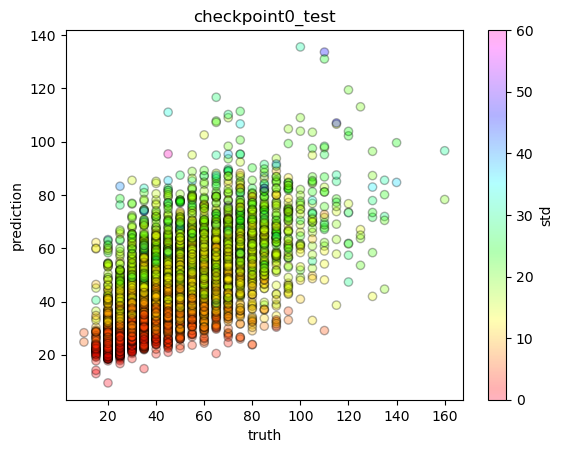

In [158]:
import matplotlib.pyplot as plt

sc=plt.scatter(truth,prediction,c=std,cmap='gist_rainbow', vmin=0, vmax=60, edgecolor='k',alpha=0.3)
plt.title('checkpoint0_test')
cbar = plt.colorbar(sc)
cbar.set_label('std')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.savefig('figures/checkpoint0_test.png', dpi=300, format='png')
plt.show()

In [159]:
std_train=np.sqrt(np.exp(2.0 * logstd_train))

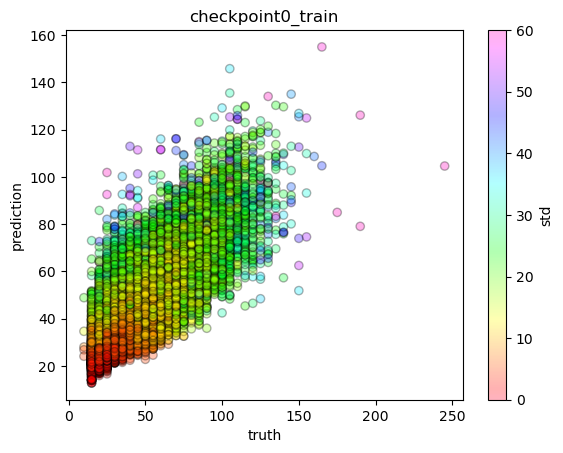

In [160]:
import matplotlib.pyplot as plt

sc=plt.scatter(truth_train,prediction_train,c=std_train,cmap='gist_rainbow', vmin=0, vmax=60, edgecolor='k',alpha=0.3)
plt.title('checkpoint0_train')
cbar = plt.colorbar(sc)
cbar.set_label('std')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.savefig('figures/checkpoint0_train.png', dpi=300, format='png')
plt.show()

In [161]:
std_val=np.sqrt(np.exp(2.0 * logstd_val))

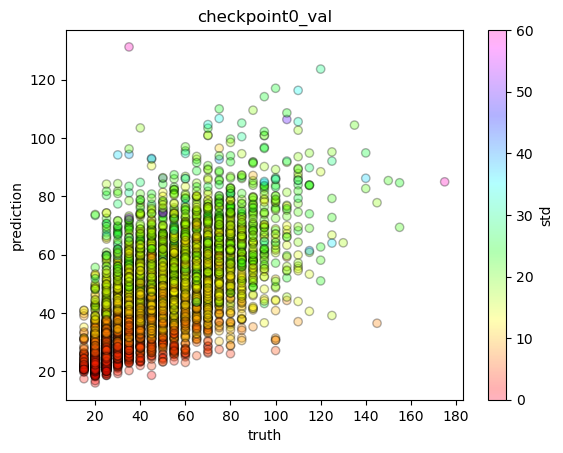

In [162]:
import matplotlib.pyplot as plt

sc=plt.scatter(truth_val,prediction_val,c=std_val,cmap='gist_rainbow', vmin=0, vmax=60, edgecolor='k',alpha=0.3)
plt.title('checkpoint0_val')
cbar = plt.colorbar(sc)
cbar.set_label('std')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.savefig('figures/checkpoint0_val.png', dpi=300, format='png')
plt.show()

In [163]:
from scipy import stats

train_bins=np.linspace(0.05,0.95,19)
train_bin_values=np.zeros(len(train_bins))
for jbin,x in enumerate(train_bins):
    train_covered=0
    for i in range(len(std_train)):
        x1,x2=stats.norm.interval(x, loc=prediction_train[i], scale=std_train[i])
        if(truth_train[i]>x1 and truth_train[i]<x2):
            train_covered+=1
    train_bin_values[jbin]=train_covered/len(std_train)
    
test_bins=np.linspace(0.05,0.95,19)
test_bin_values=np.zeros(len(test_bins))
for jbin,x in enumerate(test_bins):
    test_covered=0
    for i in range(len(std)):
        x1,x2=stats.norm.interval(x, loc=prediction[i], scale=std[i])
        if(truth[i]>x1 and truth[i]<x2):
            test_covered+=1
    test_bin_values[jbin]=test_covered/len(std)
    
val_bins=np.linspace(0.05,0.95,19)
val_bin_values=np.zeros(len(val_bins))
for jbin,x in enumerate(val_bins):
    val_covered=0
    for i in range(len(std_val)):
        x1,x2=stats.norm.interval(x, loc=prediction_val[i], scale=std_val[i])
        if(truth_val[i]>x1 and truth_val[i]<x2):
            val_covered+=1
    val_bin_values[jbin]=val_covered/len(std_val)

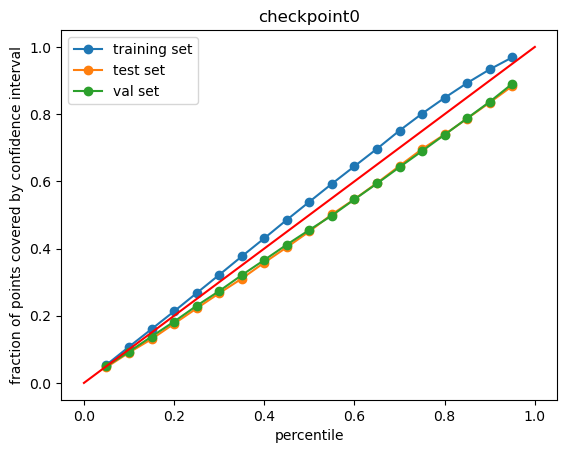

In [164]:
import matplotlib.pyplot as plt
plt.title('checkpoint0')
plt.plot(train_bins,train_bin_values,'-o',label='training set')
plt.plot(test_bins,test_bin_values,'-o',label='test set')
plt.plot(val_bins,val_bin_values,'-o',label='val set')
plt.plot([0,1],[0,1],color='red')
plt.xlabel('percentile')
plt.ylabel('fraction of points covered by confidence interval')
plt.legend()
plt.savefig('figures/checkpoint0_calibration.png', dpi=300, format='png')
plt.show()

## Ensemble avaraging

In [61]:
path="/Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/"

In [62]:
data=CGCNNDataModule(root_dir='/Users/elena.patyukova/Documents/github/Uncertainty-quntification/data/cgcnn_data', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=123)

In [165]:
test_loader=data.predict_dataloader(shuffle=False)
train_loader=data.train_dataloader(shuffle=False)
val_loader=data.val_dataloader(shuffle=False)

In [166]:
model = CGCNNLightning(**config)

Model size: 84802 parameters

Using RobustL2Loss for regression task


In [167]:
trainer = Trainer(max_epochs=5,accelerator='gpu', devices=1, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=config['patience']), 
                             ModelCheckpoint(monitor='val_mae', mode="min", 
                                dirpath='cgcnn_models/cgcnn_trained_models/', filename='eform-{epoch:02d}-{val_acc:.2f}')])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [168]:
# this won't work as test_dataloaders each time have different order.. 
# need to do one test dataloader and apply all trained models on the same sequence of test samples for all models

In [169]:
dataset = CIFData(root_dir='/Users/elena.patyukova/Documents/github/Uncertainty-quntification/data/cgcnn_data', max_num_nbr=12, radius=10, dmin=0, step=0.2)
total_size = len(dataset)

train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

In [170]:
print(train_size,val_size,test_size)

60526 7565 7567


In [171]:
num_models=4

all_mean_test=np.zeros((num_models,test_size))
all_std_test=np.zeros((num_models,test_size))

all_mean_train=np.zeros((num_models,train_size))
all_std_train=np.zeros((num_models,train_size))

all_mean_val=np.zeros((num_models,val_size))
all_std_val=np.zeros((num_models,val_size))

for i in range(num_models):
    pred = trainer.predict(model, test_loader, ckpt_path=path+"checkpoint"+str(i)+".ckpt")
    pred_train = trainer.predict(model, train_loader, ckpt_path=path+"checkpoint"+str(i)+".ckpt")
    pred_val = trainer.predict(model, val_loader, ckpt_path=path+"checkpoint"+str(i)+".ckpt")
 
    truth_test=[]
    prediction_test=[]
    logstd_test=[]

    for idx in range(30):
        truth_test.append(pred[idx][2])
        prediction_test.append(pred[idx][0])
        logstd_test.append(pred[idx][1])
    truth_test=torch.cat(truth_test,dim=0).squeeze(-1)
    prediction_test=torch.cat(prediction_test,dim=0).squeeze(-1)
    logstd_test=torch.cat(logstd_test,dim=0).squeeze(-1)
    
    std_test=np.sqrt(np.exp(2.0 * logstd_test))
    
    all_mean_test[i,:]=prediction_test
    all_std_test[i,:]=std_test

    truth_train=[]
    prediction_train=[]
    logstd_train=[]

    for idx in range(237):
        truth_train.append(pred_train[idx][2])
        prediction_train.append(pred_train[idx][0])
        logstd_train.append(pred_train[idx][1])
    truth_train=torch.cat(truth_train,dim=0).squeeze(-1)
    prediction_train=torch.cat(prediction_train,dim=0).squeeze(-1)
    logstd_train=torch.cat(logstd_train,dim=0).squeeze(-1)
    
    std_train=np.sqrt(np.exp(2.0 * logstd_train))
    
    all_mean_train[i,:]=prediction_train
    all_std_train[i,:]=std_train

    truth_val=[]
    prediction_val=[]
    logstd_val=[]
    
    for idx in range(30):
        truth_val.append(pred_val[idx][2])
        prediction_val.append(pred_val[idx][0])
        logstd_val.append(pred_val[idx][1])
    truth_val=torch.cat(truth_val,dim=0).squeeze(-1)
    prediction_val=torch.cat(prediction_val,dim=0).squeeze(-1)
    logstd_val=torch.cat(logstd_val,dim=0).squeeze(-1)
    
    std_val=np.sqrt(np.exp(2.0 * logstd_val))

    all_mean_val[i,:]=prediction_val
    all_std_val[i,:]=std_val

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint0.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint0.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint0.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint0.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint0.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint0.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint1.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint1.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint1.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint1.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint1.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint1.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint2.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint2.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint2.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint2.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint2.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint2.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint3.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint3.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint3.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint3.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint3.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/Uncertainty-quntification/cgcnn_models/cgcnn_trained_models/old_models/checkpoint3.ckpt


Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [178]:
mean_test=np.zeros(test_size)
std_test=np.zeros(test_size)
std_testa=np.zeros(test_size)
std_teste=np.zeros(test_size)

mean_train=np.zeros(train_size)
std_train=np.zeros(train_size)
std_traina=np.zeros(train_size)
std_traine=np.zeros(train_size)

mean_val=np.zeros(val_size)
std_val=np.zeros(val_size)
std_vala=np.zeros(val_size)
std_vale=np.zeros(val_size)

for i in range(num_models):
    mean_test+=all_mean_test[i,:]
    mean_train+=all_mean_train[i,:]
    mean_val+=all_mean_val[i,:]
mean_test=mean_test/num_models
mean_train=mean_train/num_models
mean_val=mean_val/num_models
for i in range(num_models):
    std_teste+=(mean_test-all_mean_test[i,:])**2
    std_testa+=all_std_test[i,:]**2
    std_traine+=(mean_train-all_mean_train[i,:])**2
    std_traina+=all_std_train[i,:]**2
    std_vale+=(mean_val-all_mean_val[i,:])**2
    std_vala+=all_std_val[i,:]**2
std_test=(std_teste/(num_models)+std_testa/num_models)**0.5
std_train=(std_traine/(num_models)+std_traina/num_models)**0.5
std_val=(std_vale/(num_models)+std_vala/num_models)**0.5

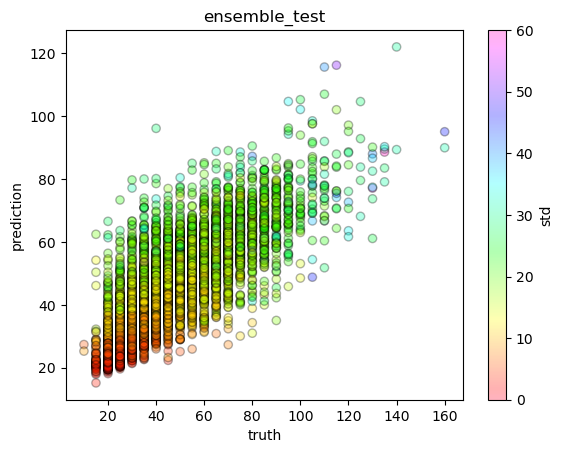

In [173]:
import matplotlib.pyplot as plt

sc=plt.scatter(truth_test,mean_test,c=std_test,cmap='gist_rainbow', vmin=0, vmax=60, edgecolor='k',alpha=0.3)
plt.title('ensemble_test')
cbar = plt.colorbar(sc)
cbar.set_label('std')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.savefig('figures/ensemble_test.png', dpi=300, format='png')
plt.show()

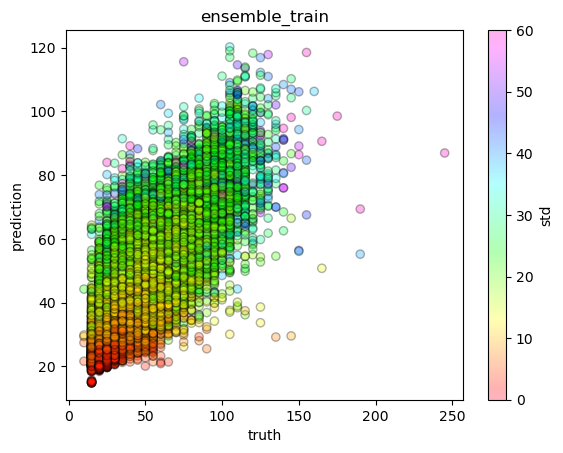

In [174]:
import matplotlib.pyplot as plt

sc=plt.scatter(truth_train,mean_train,c=std_train,cmap='gist_rainbow', vmin=0, vmax=60, edgecolor='k',alpha=0.3)
plt.title('ensemble_train')
cbar = plt.colorbar(sc)
cbar.set_label('std')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.savefig('figures/ensemble_train.png', dpi=300, format='png')
plt.show()

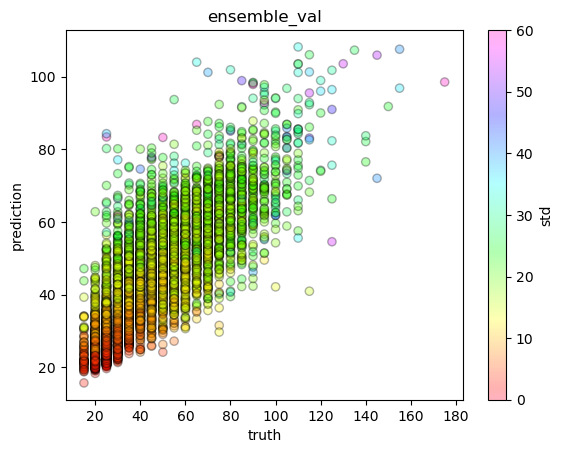

In [175]:
import matplotlib.pyplot as plt

sc=plt.scatter(truth_val,mean_val,c=std_val,cmap='gist_rainbow', vmin=0, vmax=60, edgecolor='k',alpha=0.3)
plt.title('ensemble_val')
cbar = plt.colorbar(sc)
cbar.set_label('std')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.savefig('figures/ensemble_val.png', dpi=300, format='png')
plt.show()

In [179]:
from scipy import stats

train_bins=np.linspace(0.05,0.95,19)
train_bin_values=np.zeros(len(train_bins))
for jbin,x in enumerate(train_bins):
    train_covered=0
    for i in range(len(std_train)):
        x1,x2=stats.norm.interval(x, loc=mean_train[i], scale=std_train[i])
        if(truth_train[i]>x1 and truth_train[i]<x2):
            train_covered+=1
    train_bin_values[jbin]=train_covered/len(std_train)
    
test_bins=np.linspace(0.05,0.95,19)
test_bin_values=np.zeros(len(test_bins))
for jbin,x in enumerate(test_bins):
    test_covered=0
    for i in range(len(std_test)):
        x1,x2=stats.norm.interval(x, loc=mean_test[i], scale=std_test[i])
        if(truth_test[i]>x1 and truth_test[i]<x2):
            test_covered+=1
    test_bin_values[jbin]=test_covered/len(std_test)
    
val_bins=np.linspace(0.05,0.95,19)
val_bin_values=np.zeros(len(val_bins))
for jbin,x in enumerate(val_bins):
    val_covered=0
    for i in range(len(std_val)):
        x1,x2=stats.norm.interval(x, loc=mean_val[i], scale=std_val[i])
        if(truth_val[i]>x1 and truth_val[i]<x2):
            val_covered+=1
    val_bin_values[jbin]=val_covered/len(std_val)

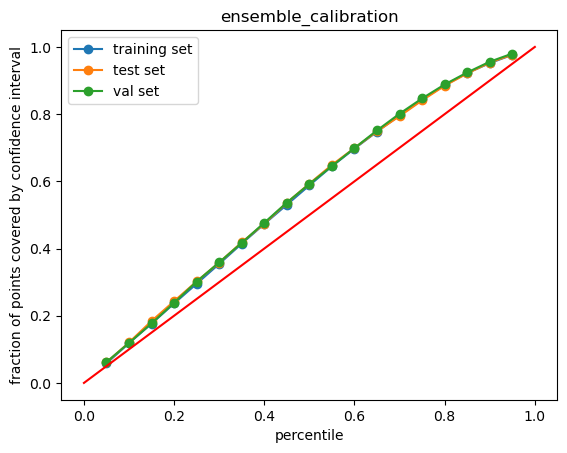

In [180]:
import matplotlib.pyplot as plt
plt.title('ensemble_calibration')
plt.plot(train_bins,train_bin_values,'-o',label='training set')
plt.plot(test_bins,test_bin_values,'-o',label='test set')
plt.plot(val_bins,val_bin_values,'-o',label='val set')
plt.plot([0,1],[0,1],color='red')
plt.xlabel('percentile')
plt.ylabel('fraction of points covered by confidence interval')
plt.legend()
plt.savefig('figures/ensemble_calibration.png', dpi=300, format='png')
plt.show()